In [1]:
import tensorflow as tf

## Creating helper functions

In [2]:
# import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

This time we're going to see how we can use the pre-trained models within `tf.keras.application` and apply them to our own problem (recognizing images of food).

In [3]:
# Check out how many images and subdirectoires are in our dataset
walk_through_dir("Data/10_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\steak'.
There are 0 di

In [4]:
# Create training and test directroy paths
train_dir = "Data/10_food_classes_10_percent/train"
test_dir = "Data/10_food_classes_10_percent/test"

In [5]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size= IMG_SIZE,
                                                                           label_mode= 'categorical',
                                                                           batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size = IMG_SIZE,
                                                                          label_mode='categorical',
                                                                          batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# Check the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[9.57142830e+00 1.09285717e+01 1.18571434e+01]
   [1.68826542e+01 1.69540825e+01 2.65969410e+01]
   [1.75714302e+01 1.60000000e+01 3.80765305e+01]
   ...
   [1.40392807e+02 1.43392807e+02 1.50392807e+02]
   [1.10321579e+02 1.11393021e+02 1.15035812e+02]
   [1.42178665e+02 1.42178665e+02 1.41464310e+02]]

  [[1.09285717e+01 1.09285717e+01 1.22142859e+01]
   [1.60000000e+01 1.50000000e+01 2.27857151e+01]
   [1.63010216e+01 1.52857141e+01 3.00153046e+01]
   ...
   [1.19157829e+02 1.22157829e+02 1.27698601e+02]
   [1.10408272e+02 1.11413376e+02 1.15255180e+02]
   [1.30632767e+02 1.30632767e+02 1.29918411e+02]]

  [[1.09336739e+01 8.29081631e+00 1.15051022e+01]
   [1.31428576e+01 1.05000000e+01 1.52857141e+01]
   [1.35255098e+01 1.13571424e+01 1.61734695e+01]
   ...
   [1.23055603e+02 1.26055603e+02 1.31484131e+02]
   [9.54540863e+01 9.64540863e+01 1.00311203e+02]
   [9.72042084e+01 9.72042084e+01 9.72042084e+01]]

  ...

  [[2.32306717e+02 2.31235703e+02 2.41092758e+02]
   [2

#### Model 0: Building a tranfer learning model using the Keras Functional API

In [9]:
# 1. Create base model with tf.keras.application
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# 4. If using a model like ResNet50v2you will need to normalize the input (you don't have to for efficientnet they have it in builtin)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number od computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=int(0.25 * len(test_data_10_percent)),
                                callbacks= [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                       experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231201-015834
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.9192 - accuracy: 0.4227 - val_loss: 1.3746 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.1481 - accuracy: 0.7640 - val_loss: 0.9207 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.8468 - accuracy: 0.8267 - val_loss: 0.7214 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6829 - accuracy: 0.8573 - val_loss: 0.6365 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.5851 - accuracy: 0.8800 - val_loss: 0.5656 - val_accuracy: 0.8536


In [10]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 51s 640ms/step - loss: 0.5662 - accuracy: 0.8600


[0.5661749243736267, 0.8600000143051147]

In [11]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [12]:
# Summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [13]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

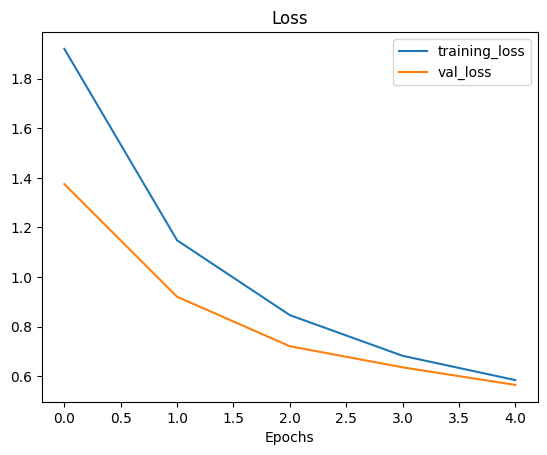

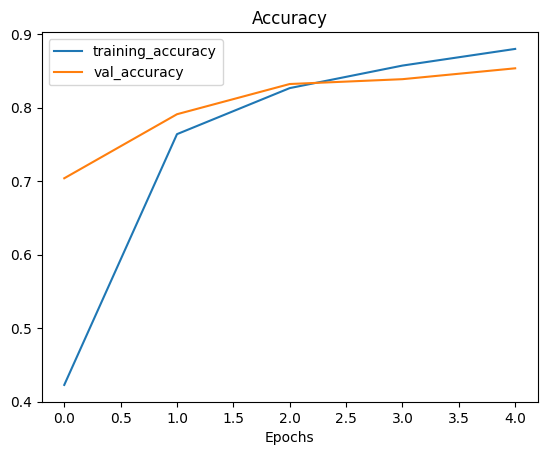

In [14]:
# Check put our model training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes trough GlobalAveragePooling2D, it turns into (None, 1280).

Let;s use similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [15]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

#pass the random tensor through the GlobalAveragePolling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [16]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Running a series a Transfer learning experiments

1. `model_1` - use feature extraction tranfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction tranfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning tranfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning tranfer learning on 100% of the training data with data augmentation.

# Model_1

In [17]:
train_dir_1_percent = "Data/10_food_classes_1_percent/train"
test_dir = "Data/10_food_classes_1_percent/test"

In [18]:
# How many images are we working with
walk_through_dir("Data/10_food_classes_1_percent")

There are 2 directories and 0 images in 'Data/10_food_classes_1_percent'.
There are 10 directories and 0 images in 'Data/10_food_classes_1_percent\test'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in 'Data/10_food_classes_1_percent\test\steak'.
There are 0 directories a

In [19]:
# Set up data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right in to the model

To add data augmentation right into our models, we can use the layers inside:
- `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation inside the model are:
* Preprocessing if images (augmenting them) heppens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
   # layers.Rescale(1./255) # Keep the models like ResNet50V2 but efficientNet's having rescaling builtin
], name = "data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 497.5, 523.5, -0.5)

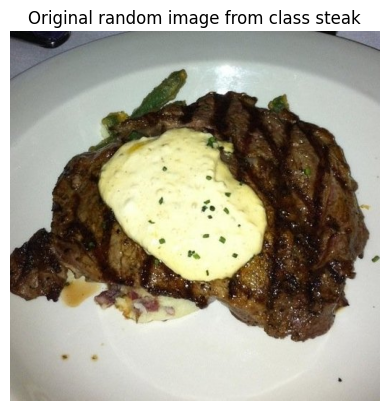

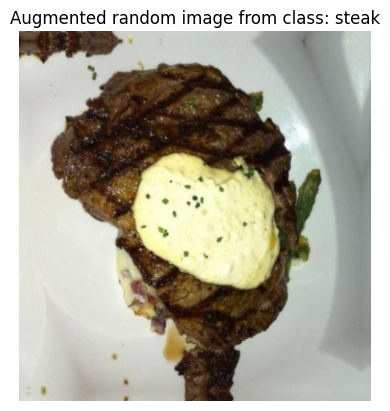

In [21]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "Data/10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

#Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

#Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction tranfer learning on 1% of the data with data augmentation

In [22]:
# Setup input shape and base model, freezing the input shape
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name='input_layer')

# Add in data augmentation Sequential model as a ley
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't turn train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as  the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_1_percent),
                       validation_data=test_data,
                       validation_steps=int(0.25* len(test_data)),
                       # Track model training logs
                       callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231201-020154
Epoch 1/5
3/3 [==============================] - 23s 7s/step - loss: 2.3406 - accuracy: 0.1429 - val_loss: 2.1595 - val_accuracy: 0.2286
Epoch 2/5
3/3 [==============================] - 14s 6s/step - loss: 2.1309 - accuracy: 0.2286 - val_loss: 2.0397 - val_accuracy: 0.2977
Epoch 3/5
3/3 [==============================] - 14s 7s/step - loss: 1.9232 - accuracy: 0.4000 - val_loss: 1.9533 - val_accuracy: 0.3503
Epoch 4/5
3/3 [==============================] - 14s 7s/step - loss: 1.8277 - accuracy: 0.4429 - val_loss: 1.8482 - val_accuracy: 0.4211
Epoch 5/5
3/3 [==============================] - 14s 7s/step - loss: 1.6514 - accuracy: 0.6000 - val_loss: 1.7885 - val_accuracy: 0.4424


In [23]:
# check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [24]:
# Evalute on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 52s 656ms/step - loss: 1.7794 - accuracy: 0.4508


[1.7794431447982788, 0.45080000162124634]

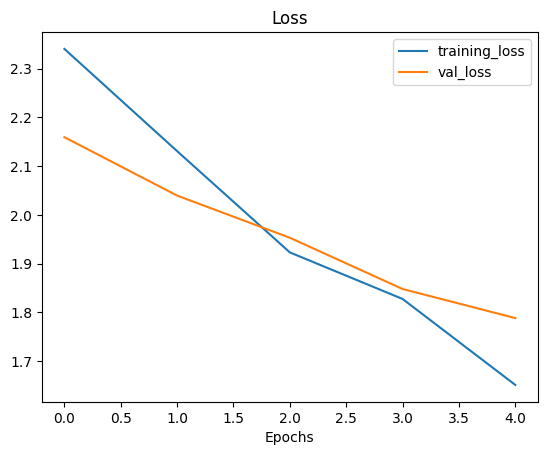

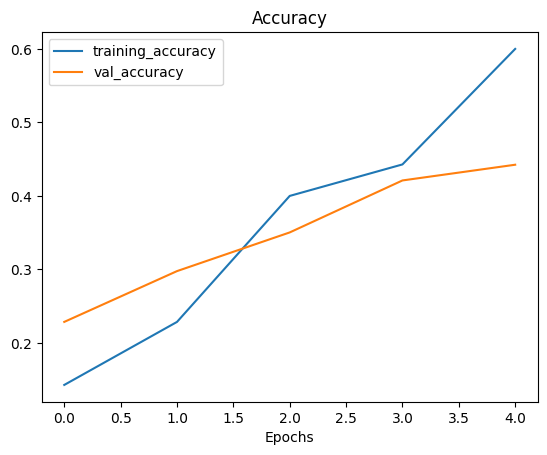

In [25]:
# How do the model with 1% of the data augmentation loss curves look? 
plot_loss_curves(history_1)

## Model 2: Feature Extraction tranfer learning model with 10% of data augmentation 

In [26]:
train_dir_10_percent = "Data/10_food_classes_10_percent/train"
test_dir = "Data/10_food_classes_10_percent/test"

In [27]:
# How many images are in our directories
walk_through_dir("Data/10_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'Data/10_food_classes_10_percent\test\steak'.
There are 0 di

In [28]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Built data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # layers.Rescaling(1./255) # if yout're using model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape = input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training = False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
               optimizer= tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [30]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the fill model or just the weights) during training. This is useful so we can come and start where we left off.

In [31]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that savess the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch", # save every epoch
                                                        verbose=1)

## Fit model 2 passing in the ModelCheckpoint callback

In [32]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                         epochs=initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                               experiment_name="10_percent_data_aug"),
                                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231201-020414
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0406 - accuracy: 0.3093
Epoch 1: saving model to ten_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 42s 1s/step - loss: 2.0406 - accuracy: 0.3093 - val_loss: 1.4781 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3850 - accuracy: 0.6640
Epoch 2: saving model to ten_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 32s 1s/step - loss: 1.3850 - accuracy: 0.6640 - val_loss: 0.9978 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0738 - accuracy: 0.7427
Epoch 3: saving model to ten_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 32s 1s/step - loss: 1.0738 - accuracy: 0.7427 - val_loss: 0.7975 - val_accuracy: 0.8191
Epoch 4/5
24/

In [33]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 54s 678ms/step - loss: 0.6471 - accuracy: 0.8272


[0.6470556855201721, 0.8271999955177307]

In [34]:
# Comparing model 0 and model 2 evaluation
model_0.evaluate(test_data)

79/79 [==============================] - 54s 667ms/step - loss: 0.5662 - accuracy: 0.8600


[0.5661749839782715, 0.8600000143051147]

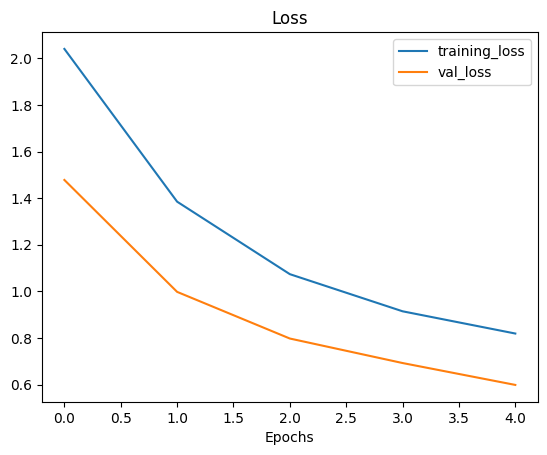

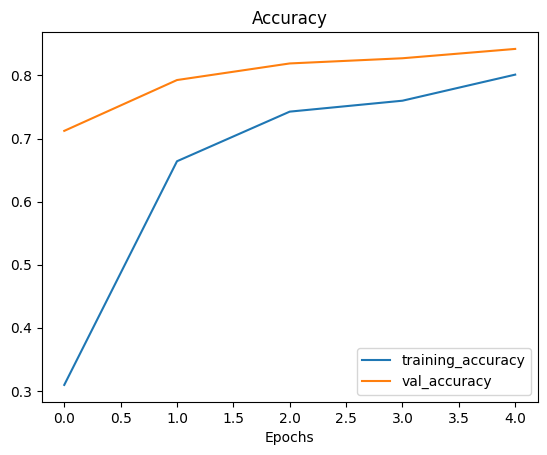

In [35]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [36]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [37]:
# Evalute model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 53s 663ms/step - loss: 0.6471 - accuracy: 0.8272


In [38]:
# Check to see if the loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [39]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-tuing an existing model on 10% of the data

>**Note**: Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

> **Note**:  In fine-tuning the always the top layers learns the bigger details from the data, while the bottom layer learns the smaller details from the data 

In [40]:
# Layer in our loaded model
model_2.layers

In [41]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x000001D596F56B90> True
<keras.src.engine.sequential.Sequential object at 0x000001D5965EACB0> True
<keras.src.engine.functional.Functional object at 0x000001D596F72380> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001D5FFEC1CC0> True
<keras.src.layers.core.dense.Dense object at 0x000001D596FC3730> True


In [42]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [43]:
# Waht layers are in our base_model (EfficientNetB0) and are they trainable?
for i , layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [44]:
# How many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainble = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Wehn fine-tuning you typically want to lower the learning rate by 10x.
               metrics=['accuracy'])

>**Note**: When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This a hyperparameter you can tune. But a good rule of thumb is atleast 10x (through different sources will claim other values)

In [46]:
# Check which layers are tunable (trainble)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [47]:
# Now ew've unfrozen some of the layers closer to the top, how many trainble varailbes are there?
print(len(model_2.trainable_variables))

2


In [48]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 wxcept with more trainble layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs = fine_tune_epochs,
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                    experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231201-020947
Epoch 5/10
24/24 [==============================] - 40s 1s/step - loss: 0.7494 - accuracy: 0.8147 - val_loss: 0.6265 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 30s 1s/step - loss: 0.7445 - accuracy: 0.8160 - val_loss: 0.6002 - val_accuracy: 0.8388
Epoch 7/10
24/24 [==============================] - 31s 1s/step - loss: 0.7472 - accuracy: 0.8160 - val_loss: 0.5991 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 32s 1s/step - loss: 0.7315 - accuracy: 0.8133 - val_loss: 0.5909 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 32s 1s/step - loss: 0.7126 - accuracy: 0.8227 - val_loss: 0.5750 - val_accuracy: 0.8454
Epoch 10/10
24/24 [==============================] - 32s 1s/step - loss: 0.7223 - accuracy: 0.8333 - val_loss: 0.5805 - val_accuracy: 0.8438


In [49]:
# Evaluate the fine-tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 53s 665ms/step - loss: 0.6016 - accuracy: 0.8364


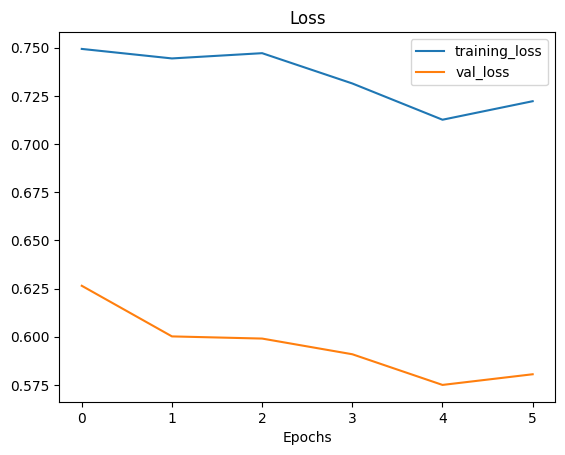

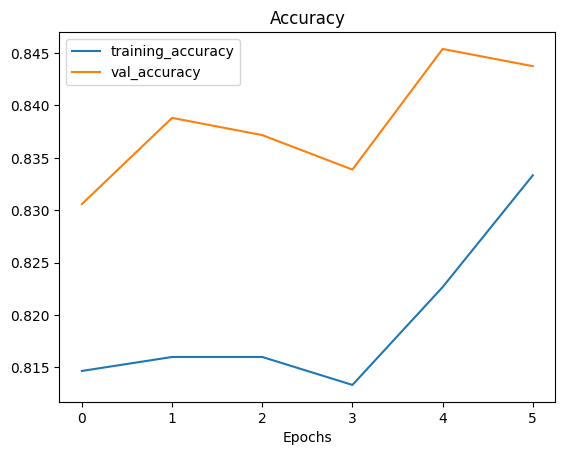

In [50]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works greate with models which have only been fit once. however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [51]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compare two TensorFlow History Objects.
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original history metrics with new history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plots for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Trainin Accuracy")
    plt.plot(total_val_acc, label = "Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc = "lower right")
    plt.title("Training and Validation Accuracy")

    # Make plots for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_loss, label="Trainin Loss")
    plt.plot(total_val_loss, label = "Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc = "upper right")
    plt.title("Training and Validation Loss")

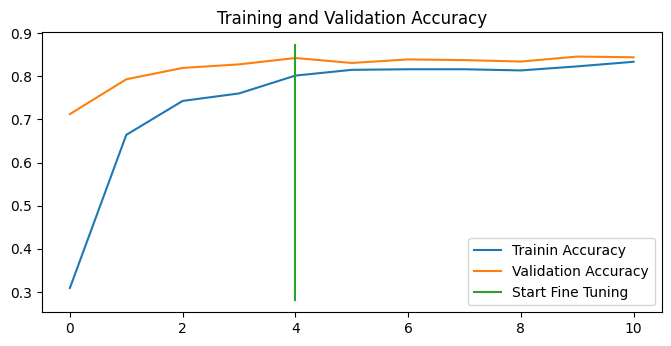

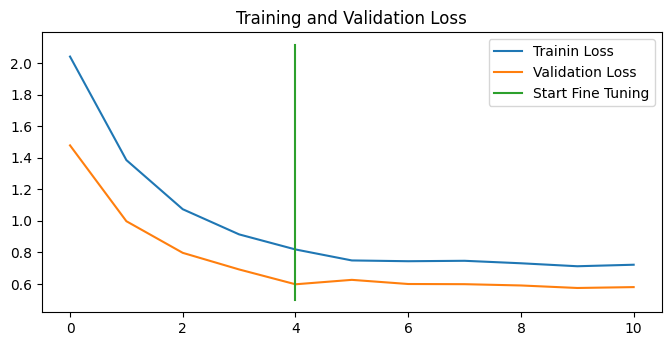

In [52]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug, initial_epochs=5)

## Model 4: Fine-tuneing and existing model on all of the data 

In [53]:
# Setup training and test dir
train_dir_all_data = "Data/10_food_classes_all_data/train"
test_dir = "Data/10_food_classes_all_data/test"

In [54]:
# How many images are we working with now?
walk_through_dir("Data/10_food_classes_all_data")

There are 2 directories and 0 images in 'Data/10_food_classes_all_data'.
There are 10 directories and 0 images in 'Data/10_food_classes_all_data\test'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in 'Data/10_food_classes_all_data\test\steak'.
There are 0 directories and 250 imag

In [55]:
# Setup data inputs 
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### To train a fine-tuning model(model_4) we need to revert model_2 back to its feature extraction weights.

In [56]:
model_2.evaluate(test_data)

79/79 [==============================] - 51s 643ms/step - loss: 0.6016 - accuracy: 0.8364


[0.6016207933425903, 0.8363999724388123]

In [57]:
results_fine_tune_10_percent

[0.6016207933425903, 0.8363999724388123]

In [58]:
# Load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [59]:
#Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 49s 614ms/step - loss: 0.6471 - accuracy: 0.8272


[0.6470556855201721, 0.8271999955177307]

In [60]:
#  Check to see of our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6470556855201721, 0.8271999955177307]

Alright, all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 payers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps 2 except this time we're going to use all of the data (model_4)

In [62]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [67]:
# unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

In [68]:
# Let's drill into our base model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [70]:
# Compile
model_2.compile(loss = "categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20231201-024706
Epoch 5/10
235/235 [==============================] - 266s 1s/step - loss: 0.7147 - accuracy: 0.7727 - val_loss: 0.4140 - val_accuracy: 0.8536
Epoch 6/10
235/235 [==============================] - 208s 883ms/step - loss: 0.5877 - accuracy: 0.8111 - val_loss: 0.3689 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 211s 895ms/step - loss: 0.5414 - accuracy: 0.8272 - val_loss: 0.3262 - val_accuracy: 0.8832
Epoch 8/10
235/235 [==============================] - 207s 880ms/step - loss: 0.4995 - accuracy: 0.8393 - val_loss: 0.3280 - val_accuracy: 0.8832
Epoch 9/10
235/235 [==============================] - 204s 868ms/step - loss: 0.4789 - accuracy: 0.8403 - val_loss: 0.3139 - val_accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 207s 882ms/step - loss: 0.4489 - accuracy: 0.8549 - val_loss: 0.3017 - val_accuracy: 0.8947


In [71]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 57s 716ms/step - loss: 0.2691 - accuracy: 0.9100


[0.2690528929233551, 0.9100000262260437]

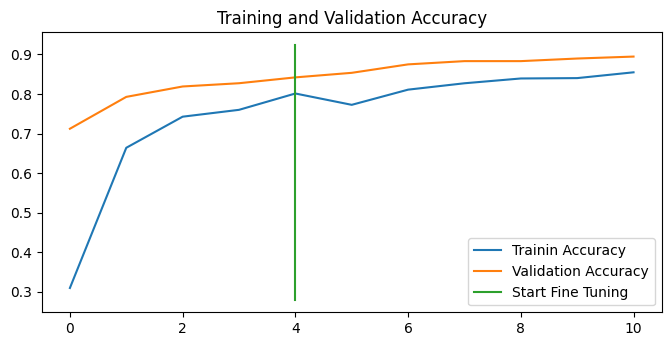

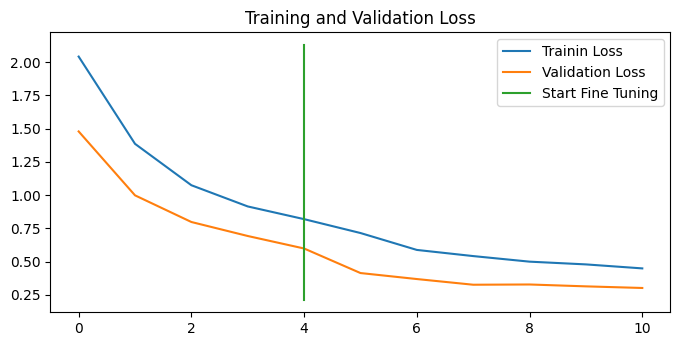

In [72]:
# How did fine-tuning go with more data?
compare_historys(history_10_percent_data_aug, history_fine_10_classes_full, initial_epochs=5)